# Fully connected Deep Neural Network

We now present the implementation of a fully connected Deep Neural Network that identifies classes from the ASL (American Sign Language) dataset.

We will divide this in 2 parts:
1. The preparation of the data
2. The implementation of the model

## 1. Data preparation

### Imports

In [13]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

### Data Exploration
It's a good idea to explore the dataset to get a notion of some of the parameters that our model will be using.
- We notice that our training dataset is made of `27455` in our training set and `7172` in our validation set.
- We can observe that our sets have `785` columns, specifically the one titled 'label' corresponds to our target variable and contains `24` different classes, this give us an idea of the number of units in our output layer.
- We also notice that the remaining number of columns is `784` which is result of 28x28, which would indicate that the images have been already flattened in the dataset. We can test this by building a function that re-sizes the images to their original size and plot them. 
- The values of the dataframe are all integers. Given that neural networks are sensitive to the scale of input features (weights are typically initialized to small random values), and that the gradient descent can compute gradients that can be different in magnitude across features, it's a good idea to normalize the data to avoid issues with the stability of our training.
- The values in our pixels are from 0 to 255




In [14]:
# Lets load the data
DATA_PATH = '.'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))
print(f"shape of train_df: {train_df.shape}")
print(f"shape of valid_df: {valid_df.shape}")
print(f"number of classes: {valid_df.label.nunique()}")
# Get min and max pixel values
pixel_max = max(train_df.iloc[:, 1:].max().max(), valid_df.iloc[:, 1:].max().max())
pixel_min = min(train_df.iloc[:, 1:].min().min(), valid_df.iloc[:, 1:].min().min())
print(f"Pixel value range: min = {pixel_min}, max = {pixel_max}")

train_df.head()

shape of train_df: (27455, 785)
shape of valid_df: (7172, 785)
number of classes: 24
Pixel value range: min = 0, max = 255


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


#### Utility functions for the data preprocessing stage

In this section we will build some utility functions that will help us with some specific tasks, such as:
- data splits 
- data normalization
- data visualization



In [15]:

#### ---------- Utility functions ----------
def get_asl_alphabet():
    """
    Returns a list of lowercase letters excluding 'j' and 'z' which are used in ASL.
    The ASL dataset excludes 'j' and 'z' because they require motion and cannot be represented in static images.
    In order to identify our 24 classes we will need to match the selected 24 letters with the 24 classes in our dataset.
    
    Returns:
        list: List of 24 lowercase letters used in static ASL hand positions
    """
    alphabet = list(string.ascii_lowercase)
    alphabet.remove('j')  # The letter 'j' in ASL requires motion
    alphabet.remove('z')  # The letter 'z' in ASL requires motion
    return alphabet

### ---------- Data splitting functions ----------
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Split data into validation and test sets.
    
    Args:
        x (np.ndarray): Input features
        y (np.ndarray): Labels
        pct (float): Percentage of data to use for validation (default: 0.5)
        shuffle (bool): Whether to shuffle the data before splitting (default: True)
    
    Returns:
        tuple: (x_val, y_val, x_test, y_test)
    '''
    n_samples = len(x)
    indices = np.arange(n_samples)
    
    if shuffle:
        np.random.shuffle(indices)
    
    split_idx = int(n_samples * pct)
    val_indices = indices[:split_idx]
    test_indices = indices[split_idx:]
    
    return x[val_indices], y[val_indices], x[test_indices], y[test_indices]

#### ---------- Normalization functions ----------
def normalize_data(x_train, x_val, x_test):
    """
    Normalize image data to [0,1] range by dividing by 255.
    
    Args:
        x_train (np.ndarray): Training data
        x_val (np.ndarray): Validation data
        x_test (np.ndarray): Test data
        
    Returns:
        tuple: Normalized (x_train, x_val, x_test)
    """
    # Normalize to [0,1] range
    x_train_norm = x_train / 255.0
    x_val_norm = x_val / 255.0
    x_test_norm = x_test / 255.0
    
    return x_train_norm, x_val_norm, x_test_norm

### ---------- Minibatch generator ----------
def create_minibatches(mb_size, x, y, shuffle=True):
    """
    Creates mini-batches from input data for training neural networks.
    Discussion:

    "Mini-batch gradient descent can be understood as applying full batch gradient descent 
    to smaller subsets of the training data, for example, 32 training examples at a time. 
    The advantage over full batch gradient descent is that convergence is reached faster 
    via mini-batches because of the more frequent weight updates."
    ![Machine Learning with PyTorch and Scikit-Learn](https://learning.oreilly.com/library/view/machine-learning-with/9781801819312/Text/Chapter_2.xhtml#_idParaDest-48)
    Args:
        mb_size (int): Size of each mini-batch
        x (np.ndarray): Input features array of shape (n_samples, 784)
        y (np.ndarray): Target labels array of shape (n_samples, 1)
        shuffle (bool, optional): Whether to shuffle the data before creating mini-batches. 
                                Defaults to True.
    
    Returns:
        generator: Generator yielding tuples of (x_batch, y_batch), where each batch
                 has shape (mb_size, 784) for x_batch and (mb_size, 1) for y_batch
    
    Raises:
        AssertionError: If the number of samples in x and y don't match
    
    Example:
        >>> x_data = np.random.rand(1000, 784)
        >>> y_data = np.random.rand(1000, 1)
        >>> batches = create_minibatches(32, x_data, y_data)
        >>> for x_batch, y_batch in batches:
        ...     # Process each batch
        ...     pass
    """    
    assert x.shape[0] == y.shape[0], 'Error: number of samples in x and y must match'
    total_data = x.shape[0]
    
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    
    minibatch = ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))
    return minibatch

#### ---------- Data visualization functions ----------
def plot_sign(image, label=None, predicted=None):
    """
    Plot a single ASL sign image with optional label information.
    
    Args:
        image (np.ndarray): Image data in shape (784,) or (28,28)
        label (int, optional): True label index
        predicted (int, optional): Predicted label index
    """
    # Reshape if the image is flattened
    if image.shape != (28, 28):
        image = image.reshape(28, 28)
    
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
    # Add title with label information if provided
    if label is not None and predicted is not None:
        title = f'True: {get_asl_alphabet()[label]}'
        if predicted is not None:
            title += f' | Predicted: {get_asl_alphabet()[predicted]}'
        plt.title(title)
    
    plt.show()

def plot_sample_signs(x_data, y_data, num_samples=5):
    """
    Plot multiple random samples from the dataset.
    
    Args:
        x_data (np.ndarray): Image data
        y_data (np.ndarray): Labels
        num_samples (int): Number of samples to plot
    """
    plt.figure(figsize=(15, 3))
    
    for i in range(num_samples):
        idx = np.random.randint(len(y_data))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')
        plt.title(f'Label: {get_asl_alphabet()[y_data[idx]]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


### Data processing

Now with all our utilities in place, we can proceed to prepare our data in a format that our model can work with.
1. Separate our features from our target variables 
2. Our data is made of integers, we will convert them to floats.
3. We will divide our data into training, validation and test dataframes
4. Then we will proceed with the normalization.
5. And finally we will inspect the shape of our dataframes to make sure they are in the correct format and we will plot some of the images from the ASL dataset.



x_train_norm.shape: (27455, 784)
x_val_norm.shape: (3586, 784)
x_test_norm.shape: (3586, 784)


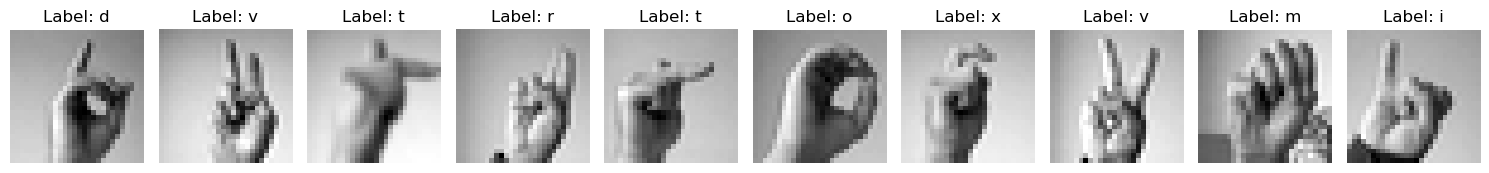

In [16]:
# 1. separate our features from our target variables 
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
# And remove it from our train_df and valid_df dataframes
del train_df['label']
del valid_df['label']

# 2.Cast to float32
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

# 3. Split data into training, validation and test sets
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

# 4. Normalize data
x_train_norm, x_val_norm, x_test_norm = normalize_data(x_train, x_val, x_test)

# 5. Inspect the shape of our dataframes to make sure they are in the correct format and we will plot some of the images from the ASL dataset.
print(f"x_train_norm.shape: {x_train_norm.shape}")
print(f"x_val_norm.shape: {x_val_norm.shape}")
print(f"x_test_norm.shape: {x_test_norm.shape}")
# Plot 10 random samples from validation data
plot_sample_signs(x_train, y_train, num_samples=10)

# Model implementation
Before implemeting our model, let's understand our model's architecture.
We will examine the state of our matrices through the forward and the backward pass.


Please notice: For simplicity we will use a single hidden layer to derive our equations. And we have ommited the bias term for now.

## The fully connected DNN

![Model](./mlp_1_layer.png)

Our model consist of 3 layers
- The input layer: It contains 784 units, same as our input features. 
- The hidden layer: For this layer we have selected the same number as our mnist classifier (200 units). This is a hyperparameter that we can tune.
- The output layer with 24 units, same as the number of classes in our ASL dataset.

Some comments to understand the diagram
- Each circle in the diagram also know as a neuron or unit. Technically, for the first input layer, these units are just constants as we are using the values from our flattened image. But the units in the hidden and output layers do apply some processing to the data, for example, the hidden layer applies a ReLU activation function, sometimes these units are called "activation units". Same as the output layer, which applies a softmax function, but because these units are used to classify our data, they are also called "classification units" or simply "output units". The key factor here, is that each unit (except for the input layer) involves some processing to the data.
- Connections. Notice that the Weights are connecting the units between the layers.Each unit in the input layer is connected to each unit in the hidden layer, and so on with further layers up until the last layer. Thus the name "fully connected" DNN. This means that for each unit, the output value is a linear combination of the input values, and the weights which result is pass through a ReLU activation function. 


We will have more clarity if we run a forward pass with the values we have in our dataset and our model's parameters example


## Forward pass

lets go over our first and second layer.
 
 $$z^1 = W^1 X^T + b^1$$
 $$a^1 = ReLU(z^1)$$

With the information we have gathered so far, we can proceed to define some variables of our model as:
```python
n = 512 # number of samples in mini batch (512 for this example)
m = 784 # number of input features (28x28) flattened image
d = 200 # number of hidden units (example)
t = 24 # number of output units, given by the number of classes in our target variable

# Input layer
X.shape # (n=512,m=784)
W1.shape # (d=200,m=784)
b1.shape # (d=200,1)
W2.shape # (t=24,d=200)
b2.shape # (t=24,1)
```

 Our first step will be to compute the forward pass between the input layer and the hidden layer. This can be expresed in this equations:

 $$z^1 = W^1 X^T + b^1$$
 $$a^1 = ReLU(z^1)$$

Let's visualize how the shapes of our tensors will look like during this first pass:
```python
# Z1 =    W1      @     X.T     +   b1 
#      (200, 784) @ (784, 512) + (200, 1)
Z1.shape # (200, 512)

# A1 = ReLU(Z1)
A1.shape # (200, 512)




```
IMPORTANT: Notice that we have transposed the 'X' tensor changing its shape from `(512, 784)` to `(784, 512)`. This is done to make the matrix multiplication possible. Other implementations may represent these initial tensors with different shapes, changing the implementation of the matrix multiplication for our net input function $Z$. For example: `W(d,m)` and `X(m,n)` will require to multiple `W @ X`, and `X(n,m)` and `W(d,m)` will make the multiplication: `X @ W.T`. In any case, the rules of linear algebra need to be respected and the internal dimensions need to match.


Now lets move to the next transformation, from the hidden layer to the output layer. The involved equations will be:

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


```python
# Z2 =     W2    @     A1     +  b2
#      (24, 200) @ (200, 512) + (24, 1)
Z2.shape # (24, 512)

# y^ = softmax(Z2)
y_hat.shape # (24, 512)

```

Our final output $$ \hat{y} $$ will be a tensor of shape `(24, 512)`, where each row will contain the probability of each class in our ASL dataset. And each column will contain the results for each sample in our mini batch.





# Backpropagation

Let's discuss the backpropagation process. In few words the objective of the backpropagation is to find the weights and biases that minimize the loss function. In other words, we need to optimize a function that describe the loss of our model, the amount of error that our model is making. So now we need what does the loss function looks like.

This equation calculate the loss for each sample in our mini batch.
$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$

And this equation calculate the average loss for all samples in our mini batch.

$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

We notice that the loss function depends of the last transformation of our model, the softmax function. So our first partial derivative will start the chain rule from the softmax function.
It is worth notice that our derivatives are calculated from right to left, starting from the last layer and moving to the first layer. This is more optimal in terms of computational cost.

We will to update the weights and biases of our model, and we have seen that there are more than one matrices corresponding to each layer in the model. So, depending of which matrix we are updating, the equation to obtain the gradients will be different.
But in this case, we have  a simple model with just 2 weighted layers. So we can calculate both equations here:

Let's first find the weights and biases of the output layer.

$$
\frac{\partial \mathcal{L}}{\partial w^{out}} = \frac{\partial \mathcal{L}}{\partial \text{softmax}^{out}} \cdot \frac{\partial \text{softmax}^{out}}{\partial z^{out}} \cdot \frac{\partial z^{out}}{\partial w^{out}}
$$
```markdown
- (∂L/∂softmax^out) represents the derivative of the loss with respect to the output activation (softmax)
- (∂softmax^out/∂z^out) the second term represents the derivative of the softmax function with respect to its input (the net input z)
- (∂z^out/∂w^out) the third term represents the derivative of the output's net input z with respect to the weights
```

Now let's find the gradients for the hidden layer. This one would be a bit larger:

$$
\frac{\partial \mathcal{L}}{\partial w^{h}} = \frac{\partial \mathcal{L}}{\partial \text{softmax}^{out}} \cdot \frac{\partial \text{softmax}^{out}}{\partial z^{out}} \cdot \frac{\partial z^{out}}{\partial ReLU^{h}} \cdot \frac{\partial ReLU^{h}}{\partial z^{h}} \cdot \frac{\partial z^{h}}{\partial w^{h}}
$$


```markdown
- The loss to the softmax activation function
- The softmax activation to the output's net input Z
- The output's net input Z to the hidden activation function (A ReLU)
- The hidden activation function (A ReLU) to the hidden net input Z
- The hidden net input Z to the hidden weights W
```

Now you can see that we can extend this calculation depending on the number of layers in our model. 

We practice the development of these equations so we understand the flow of the gradients through our model.
But in practice, these forward and backward passes resulting predictions and gradients are computed at the same time, so we won't see these equations explicitly implemented, but the underlaying logic will remain the same, this is: in order to compute the gradient at any given layer, we will need the value of the previous layer's gradient (moving from right to left).

This is simple because by calculating in this way, we make a better use of the computational resources.


## Implementation of the model

To mainting the simplicity of our model, we will implement a single layer linear model, that will look like this:
```python
model = Sequential_layers([
    Linear(784, 200), # Z1 = W1 @ X.T + b1
    ReLU(), # A1 = ReLU(Z1)
    Linear(200, 24)] # Z2 = W2 @ A1 + b2
)
```

We can observe that our model is incomplete, as we still need to calculate the predictions given by our softmax function as:

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$

We have moved out this function out of our model, as a result the final output of our previous model will be a raw unnormalized output, also know as logits, with a shape of `(24, 512)`. This will be the input for our softmax function.



## Cost Function (and softmax)
At this point we have calculated the afore mentioned logits, and we have the final output of our model, but these results are not yet the predictions of our model, as these are just raw scores. The softmax function will normalize these scores to a probability distribution, these normalized probabilities allow the cross-entropy loss to effectively measure how far the predicted distribution is from the true distribution. This helps our model to get a better measure of the loss.


From a more practucal perspective, we can see this function from 2 different perspectives:

1. from forward pass perspective this function will receive the last output from our model, the net input $z^2 = W^2 a^1 + b^2$ and will apply the softmax function to get the normalized probabilities:

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$

2. From the backward pass perspective, this function will calculate the cost (or loss) of our model, which is the average loss for all samples in our mini batch. And then it will compute the gradient . Giving us the first term in our partial derivative equations:

$\frac{\partial \mathcal{L}}{\partial \text{softmax}^{out}}$



In [17]:
def softmaxXEntropy(x, y):
    """
    Computes the softmax cross-entropy loss and its gradient for neural network classification.
    
    This function combines the softmax activation with cross-entropy loss calculation,
    which is commonly used as the final layer in multi-class classification problems.
    The implementation includes both the forward pass (computing probabilities and loss)
    and backward pass (computing gradients).
    
    Args:
        x (np.ndarray): Input logits of shape (num_classes, batch_size)
        y (np.ndarray): Ground truth labels of shape (batch_size,) or (1, batch_size)
                       containing class indices
    
    Returns:
        tuple: (predictions, cost)
            - predictions (np.ndarray): Class probabilities of shape (num_classes, batch_size)
            - cost (float): Average cross-entropy loss over the batch
    
    Side effects:
        - Sets x.grad with the gradient of the loss with respect to the input
        
    Notes:
        The function performs these steps:
        1. Applies softmax to convert logits to probabilities
        2. Computes cross-entropy loss
        3. Calculates gradients for backpropagation
        
        The cross-entropy loss is computed as:
        L = -1/N * Σ log(p_i) where p_i is the predicted probability of the true class
        
    Example:
        >>> logits = np.random.randn(10, 32)  # 10 classes, batch size 32
        >>> labels = np.random.randint(0, 10, (32,))
        >>> probs, loss = softmaxXEntropy(logits, labels)
    """
    batch_size = x.shape[1]
    
    # Forward pass
    exp_scores = np.exp(x)  # Compute exponentials
    probs = exp_scores / exp_scores.sum(axis=0)  # Normalize to get probabilities
    preds = probs.copy()  # Store predictions
    
    # Compute cross-entropy loss
    y_hat = probs[y.squeeze(), np.arange(batch_size)]  # Get probabilities of correct classes
    cost = np.sum(-np.log(y_hat)) / batch_size  # Average negative log likelihood
    
    # Backward pass - compute gradients
    probs[y.squeeze(), np.arange(batch_size)] -= 1  # Derivative of softmax+cross-entropy
    x.grad = probs.copy()  # Store gradients for backprop
    
    # print(f"preds.shape: {preds.shape}")
    # print(f"cost.shape: {cost.shape}")
    
    return preds, cost

## Linear Layer


In [18]:
class np_tensor(np.ndarray): pass

class Linear():
    """
    Implements a linear transformation layer for neural networks: y = Wx + b
    
    This layer performs an affine transformation using weights W and bias b,
    initialized using He initialization for better training dynamics with ReLU activations.
    
    Attributes:
        W (np_tensor): Weight matrix of shape (output_size, input_size)
        b (np_tensor): Bias vector of shape (output_size, 1)
        
    Notes:
        - Uses He initialization (sqrt(2/n)) scaled for better convergence with ReLU
        - Implements both forward pass (__call__) and backward pass (backward)
        - Gradients are stored in .grad attributes of tensors
    """
    
    def __init__(self, input_size, output_size):
        """
        Initialize the linear layer with He initialization.
        
        Args:
            input_size (int): Number of input features
            output_size (int): Number of output features
            
        Notes:
            He initialization scales weights by sqrt(2/input_size) to help with 
            training stability, especially when using ReLU activations.
        """
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
        
    def __call__(self, X):
        """
        Forward pass: compute linear transformation Z = WX + b
        
        Args:
            X (np.ndarray): Input tensor of shape (input_size, batch_size)
            
        Returns:
            np.ndarray: Output tensor of shape (output_size, batch_size)
        """
        Z = self.W @ X + self.b
        return Z
        
    def backward(self, X, Z):
        """
        Backward pass: compute gradients for weights, bias, and input
        
        Args:
            X (np_tensor): Input tensor from forward pass
            Z (np_tensor): Output tensor from forward pass with accumulated gradients in Z.grad
            
        Side effects:
            Sets the following gradient attributes:
            - X.grad: Gradient with respect to the input
            - self.W.grad: Gradient with respect to weights
            - self.b.grad: Gradient with respect to bias
            
        Notes:
            Implements the chain rule for backpropagation:
            - dL/dX = W^T @ dL/dZ
            - dL/dW = dL/dZ @ X^T
            - dL/db = sum(dL/dZ, axis=1, keepdims=True)
        """
        X.grad = self.W.T @ Z.grad
        self.W.grad = Z.grad @ X.T
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)

### ReLU Layer

In [19]:
class ReLU():
    """
    Implements the Rectified Linear Unit (ReLU) activation function.
    
    ReLU is defined as f(x) = max(0, x), which means it outputs the input directly 
    if it is positive, and zero otherwise. This non-linear activation function is 
    commonly used in neural networks due to its computational efficiency and ability 
    to help mitigate the vanishing gradient problem.
    
    Notes:
        - Forward pass (__call__): computes f(x) = max(0, x)
        - Backward pass: computes gradient as 1 for x > 0, 0 otherwise
        - No learnable parameters
    """
    
    def __call__(self, Z):
        """
        Forward pass: applies the ReLU activation function.
        
        Args:
            Z (np.ndarray): Input tensor of any shape
            
        Returns:
            np.ndarray: Output tensor of same shape as input, with negative values set to 0
        """
        return np.maximum(0, Z)
    
    def backward(self, Z, A):
        """
        Backward pass: computes gradients for ReLU activation.
        
        The gradient of ReLU is:
            - 1 for inputs that were positive
            - 0 for inputs that were negative or zero
        
        Args:
            Z (np_tensor): Input tensor from forward pass
            A (np_tensor): Output tensor from forward pass with accumulated gradients in A.grad
            
        Side effects:
            Sets Z.grad with the gradient of the loss with respect to Z
        """
        Z.grad = A.grad.copy()  # Copy upstream gradients
        Z.grad[Z <= 0] = 0      # Zero out gradients where input was negative

### Sequential Layers

In [20]:
class Sequential_layers():
    """
    Implements a sequential container for neural network layers.
    
    This class manages a sequence of layers (Linear, ReLU, etc.) and handles
    the forward pass, backward pass, and parameter updates during training.
    It maintains a cache of intermediate outputs for use in backpropagation.
    
    Attributes:
        layers (list): List of layer objects (Linear, ReLU, etc.)
        x (np.ndarray): Current input being processed
        outputs (dict): Cache of layer outputs indexed as 'l0', 'l1', etc.
    """
    
    def __init__(self, layers):
        """
        Initialize the sequential container with a list of layers.
        
        Args:
            layers (list): List of layer objects (Linear, ReLU, etc.)
        """
        self.layers = layers
        self.x = None
        self.outputs = {}
        
    def __call__(self, X):
        """
        Forward pass through all layers in sequence.
        
        Args:
            X (np.ndarray): Input tensor for the network
            
        Returns:
            np.ndarray: Output tensor after passing through all layers
            
        Notes:
            Stores intermediate outputs in self.outputs for use in backward pass
        """
        self.x = X 
        self.outputs['l0'] = self.x
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        return self.x
        
    def backward(self):
        """
        Performs backpropagation through all layers in reverse order.
        
        This method propagates gradients backward through the network,
        starting from the last layer and moving to the first layer.
        Uses stored layer outputs from forward pass to compute gradients.
        
        Notes:
            Requires forward pass to be called first to populate self.outputs
        """
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], 
                                  self.outputs['l'+str(i+1)])
    
    def update(self, learning_rate=1e-3):
        """
        Updates the parameters of all layers using gradient descent.
        
        Args:
            learning_rate (float): Learning rate for gradient descent (default: 1e-3)
            
        Notes:
            - Skips ReLU layers as they have no parameters
            - Updates both weights (W) and biases (b) for Linear layers
            - Uses the gradients stored in .grad attributes
        """
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
            
    def predict(self, X):
        """
        Makes a prediction by selecting the class with highest probability.
        
        Args:
            X (np.ndarray): Input tensor
            
        Returns:
            int: Index of the predicted class
            
        Notes:
            Uses argmax on the output of forward pass to select most likely class
        """
        return np.argmax(self.__call__(X))

### Training Loop
Now that we have all our components in place, we can proceed to build our model as:
```python
model = Sequential_layers([
    Linear(784, 200), 
    ReLU(), 
    Linear(200, 24)]
)
```

Altough theorically, the training will run a forward and backward pass, the architecture we are using will programatically run a single forward pass, and at each stage, the forward output gradients wil be calculated. To illustrate this, we can see the following example:

![flow](flows.png)




In [21]:
model = Sequential_layers([
    Linear(784, 200), 
    ReLU(), 
    Linear(200, 24)]
)

model2 = Sequential_layers([
    Linear(784, 400), 
    ReLU(), 
    Linear(400, 400), 
    ReLU(), 
    Linear(400, 24)]
)

costs = []
accuracies = []
def accuracy(x, y, mb_size):
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        pred = model2(x.T.view(np_tensor))
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
    return correct/total


def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    #print(f"mb_size: {mb_size}")
    # print(f"x_train_norm.shape: {x_train_norm.shape}")

    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train_norm, y_train)):            
            # Notice how we are transposing the x. Lets explain why:
            # Originally the we have a total of 27455 in our training dataset.
            # the create_minibatches function is returning about 53 minibatches of shape (512, 784)
            # Being more specific, each row represents a sample, and the 784 columns represent the features of each sample
            # The reason of the transpose is that our Linear Model initialize the Weights matrix as:
            # self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
            # W shape is [200, 784]. Making our original batch incompatible (from the linear algebra point of view)
            # We cannot get the dot product of [200, 784] @ [512, 784]
            # So we need to transponse x so we get X [784, 512]
            # Now we can get the dot product of W[200, 784] @ [784, 512] = [200, 512].
            # We now briefly represent the changes in the matrices results during the feed forward 
            # Z^1 = W[200, 784] X[784, 512] = [200, 512]
            # Z^2 = W[200, 200] X[200, 512] = [200, 512]                      
            # y^output = W[24, 200] X[200, 512] = [24, 512]
            # y^output = [24, 512]
            
            scores = model(x.T.view(np_tensor))
            #print(f"scores shape: {scores.shape}")
            _, cost = softmaxXEntropy(scores, y)
            model.backward()
            model.update(learning_rate)            
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')
        costs.append(cost)
        accuracies.append(accuracy(x_val, y_val, mb_size))

In [22]:
def plot_training_progress(costs, accuracies):
    """
    Plot training costs and validation accuracies over epochs.
    
    Args:
        costs (list): List of training costs per epoch
        accuracies (list): List of validation accuracies per epoch
    """
    epochs = range(1, len(costs) + 1)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot training cost
    ax1.plot(epochs, costs, 'b-', label='Training Cost')
    ax1.set_title('Training Cost over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Cost')
    ax1.grid(True)
    ax1.legend()
    
    # Plot validation accuracy
    ax2.plot(epochs, accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print final metrics
    print(f'Final training cost: {costs[-1]:.4f}')
    print(f'Final validation accuracy: {accuracies[-1]:.4f}')

### Create your model and train it

In [23]:

mb_size = 512
learning_rate = 1e-4
epochs = 100

train(model2, epochs, mb_size, learning_rate)

costo: 2.671971278776773, accuracy: 0.27495817066369216
costo: 2.485022198052357, accuracy: 0.416899051868377
costo: 2.176291893498967, accuracy: 0.4313998884551032
costo: 1.9019694262909423, accuracy: 0.5005577244841048
costo: 1.6841530480598592, accuracy: 0.552983825989961
costo: 1.5803300399655051, accuracy: 0.4997211377579476
costo: 1.978490788143396, accuracy: 0.5239821528165086
costo: 1.3301287513612843, accuracy: 0.5928611266034579
costo: 1.5800682082740718, accuracy: 0.6048522030117122
costo: 1.2412921060697617, accuracy: 0.6134969325153374
costo: 1.097112629810326, accuracy: 0.6397099832682654
costo: 0.915553022066306, accuracy: 0.6550474065811489
costo: 1.0281189152500727, accuracy: 0.6165644171779141
costo: 0.9254056829599916, accuracy: 0.6940881204684886
costo: 0.9784978909949209, accuracy: 0.6645287228109314
costo: 0.8216073662106312, accuracy: 0.6887897378694925
costo: 0.6902957029539177, accuracy: 0.6982710540992749
costo: 0.6267396041145875, accuracy: 0.6993865030674846

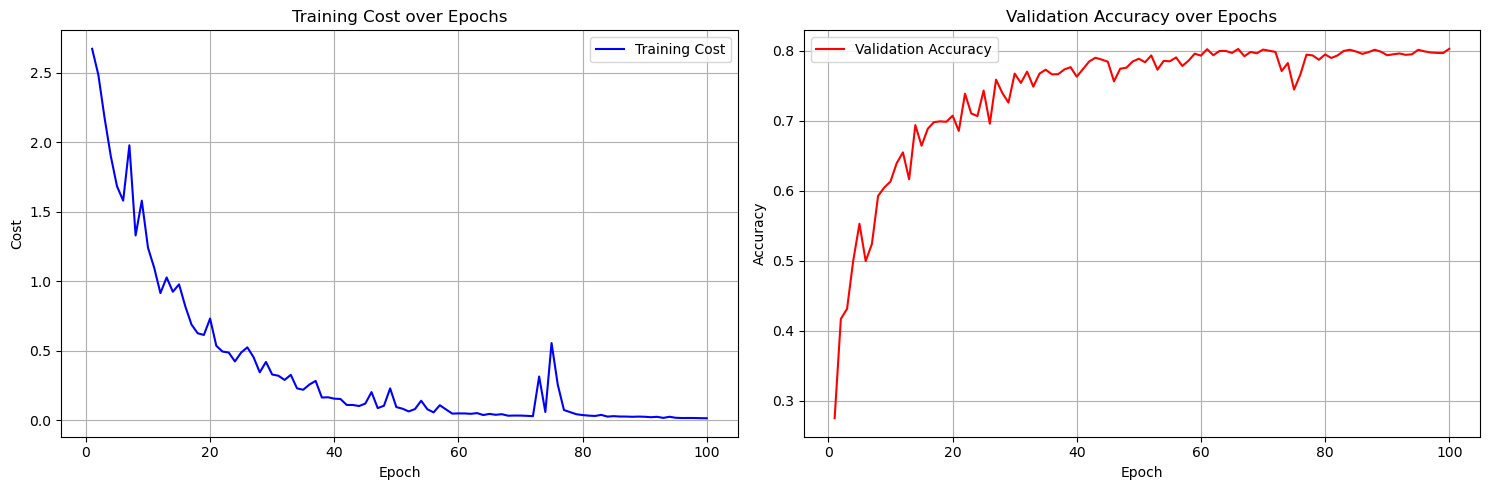

Final training cost: 0.0159
Final validation accuracy: 0.8031


In [24]:
# Plot training progress after training
plot_training_progress(costs, accuracies)